# Analyze IAP distributions + statistics in dataset

In [2]:
from src.dataset import *
from src.utils import *
from src.vizutils import *
from src.IAP_model import get_total_criterion

import os
import random
from tqdm import tqdm
import datetime

# torch
import torch
from torch import nn
from torchvision import transforms
from torchvision.models import resnet18

# GPUs
device_ids = [1] # indices of devices for models, data and otherwise
os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(str(i) for i in device_ids)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_cuda = torch.cuda.is_available()
print('running on {}'.format(device))

# set random seed
seed = 1337
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

running on cuda


In [3]:
# data and model choice
dataset_name = 'dbc_by_scanner'
labeling = 'all'

train_size = 10000
val_size = 2000
test_size = 2000

model = resnet18

checkpoint_paths = {
}

# training options
train = True
batch_size_factors = {
          'resnet18' : 64
}
checkpoint_path_prev = None
train_with_augmentations = False
save_checkpoints = True
checkpoint_setting = 'incremental'
#checkpoint_setting = 'best'


In [4]:
test_this_IAP_only = None

In [5]:
# load dataset and loader
img_size = 224
train_batchsize = batch_size_factors[model.__name__] * len(device_ids)
eval_batchsize = 64

if train_with_augmentations:
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=img_size)
    ])
    print('training with augmentations')
else:
    train_transform = transforms.Compose([])

trainset, valset, testset = get_datasets(dataset_name, 
                                train_size=train_size, 
                                val_size=val_size,
                                test_size=test_size,
                                labeling=labeling,
                                return_filenames=True,
                                different_cases_for_train_val_test=True,
                            )


trainloader = DataLoader(trainset, 
                        batch_size=train_batchsize, 
                        shuffle=True)
valloader = DataLoader(valset, 
                    batch_size=eval_batchsize)
testloader = DataLoader(testset, 
                    batch_size=eval_batchsize)

using non-default labeling: all
there are missing features for 5 patients


/workspace/src/dataset.py:41: RuntimeWarning: invalid value encountered in divide
  img = img.astype(float) * 255. / img.max()
/workspace/src/dataset.py:43: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)


number of unique patients: 917


In [24]:
print(len(trainset), len(valset), len(testset))

9952 2064 1984


## look at correlations between IAPs

In [6]:
# create df of each dataset, where each row is a datapoint with certain IAP values
data_dfs = {}
for loader_idx, loader in enumerate([trainloader, valloader, testloader]):
    data_df = None
    for _, (inputs, targets, _) in enumerate(loader):
        new_data_df = pd.DataFrame.from_dict(targets)
        
        if data_df is None:
            data_df = new_data_df
        else:
            data_df = pd.concat([data_df, new_data_df])
            
    data_dfs[['train', 'val', 'test'][loader_idx]] = data_df  

/workspace/src/dataset.py:41: RuntimeWarning: invalid value encountered in divide
  img = img.astype(float) * 255. / img.max()
/workspace/src/dataset.py:43: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)
/workspace/src/dataset.py:41: RuntimeWarning: invalid value encountered in divide
  img = img.astype(float) * 255. / img.max()
/workspace/src/dataset.py:43: RuntimeWarning: invalid value encountered in cast
  img = img.astype(np.uint8)


In [7]:
save_dir = 'IAP_analyses/correlations'
for dset_name, data_df in data_dfs.items():
    print(dset_name)
    # display(data_df)
    df_corr = data_df.corr(method='spearman')
    display(df_corr)
    
    df_corr.to_csv(os.path.join(save_dir, '{}.csv'.format(dset_name)))

train


,Manufacturer,Manufacturer Model Name,Scan Options,Patient Position During MRI,Field Strength (Tesla),Contrast Agent,Acquisition Matrix,Slice Thickness,Flip Angle \n,FOV Computed (Field of View) in cm,TE (Echo Time),TR (Repetition Time)
Manufacturer,1.000000,-0.147406,0.828251,0.622988,-0.106460,0.189262,0.683745,-0.315799,0.224413,0.015549,-0.810550,-0.810278
Manufacturer Model Name,-0.147406,1.000000,-0.125958,-0.221313,0.509974,0.022303,-0.088843,0.143779,-0.300353,-0.000346,0.181681,-0.009635
Scan Options,0.828251,-0.125958,1.000000,0.460827,0.201733,-0.018737,0.420954,-0.291237,0.214513,-0.076110,-0.705958,-0.631502
Patient Position During MRI,0.622988,-0.221313,0.460827,1.000000,-0.167964,0.119294,0.585910,-0.169934,-0.080718,-0.161785,-0.552931,-0.433598
Field Strength (Tesla),-0.106460,0.509974,0.201733,-0.167964,1.000000,-0.287984,-0.039187,-0.099127,-0.150530,-0.105636,0.190382,0.305943
Contrast Agent,0.189262,0.022303,-0.018737,0.119294,-0.287984,1.000000,0.476471,0.238663,-0.111357,0.207699,0.078062,-0.172156
Acquisition Matrix,0.683745,-0.088843,0.420954,0.585910,-0.039187,0.476471,1.000000,-0.131443,0.217416,0.054032,-0.349533,-0.411111
Slice Thickness,-0.315799,0.143779,-0.291237,-0.169934,-0.099127,0.238663,-0.131443,1.000000,-0.300228,-0.081499,0.279488,0.298437
Flip Angle \n,0.224413,-0.300353,0.214513,-0.080718,-0.150530,-0.111357,0.217416,-0.300228,1.000000,-0.075484,-0.191250,-0.162353
FOV Computed (Field of View) in cm,0.015549,-0.000346,-0.076110,-0.161785,-0.105636,0.207699,0.054032,-0.081499,-0.075484,1.000000,-0.110475,-0.275393


val


,Manufacturer,Manufacturer Model Name,Scan Options,Patient Position During MRI,Field Strength (Tesla),Contrast Agent,Acquisition Matrix,Slice Thickness,Flip Angle \n,FOV Computed (Field of View) in cm,TE (Echo Time),TR (Repetition Time)
Manufacturer,1.000000,-0.363312,0.873219,0.661887,-0.248939,-0.024591,0.557220,-0.298426,0.123760,-0.041720,-0.837650,-0.837611
Manufacturer Model Name,-0.363312,1.000000,-0.321919,-0.314794,0.542689,0.110291,-0.083805,0.142976,-0.289581,0.074130,0.387458,0.160346
Scan Options,0.873219,-0.321919,1.000000,0.522867,0.001135,-0.237360,0.322676,-0.296072,0.042031,-0.062662,-0.755379,-0.741139
Patient Position During MRI,0.661887,-0.314794,0.522867,1.000000,-0.224736,0.072330,0.569533,-0.135391,-0.075552,-0.232771,-0.599351,-0.479846
Field Strength (Tesla),-0.248939,0.542689,0.001135,-0.224736,1.000000,-0.226396,-0.023954,-0.169413,-0.195475,0.080246,0.295879,0.374443
Contrast Agent,-0.024591,0.110291,-0.237360,0.072330,-0.226396,1.000000,0.394659,0.121408,-0.068701,0.304099,0.245172,0.021984
Acquisition Matrix,0.557220,-0.083805,0.322676,0.569533,-0.023954,0.394659,1.000000,-0.019797,0.126567,0.020275,-0.361798,-0.331834
Slice Thickness,-0.298426,0.142976,-0.296072,-0.135391,-0.169413,0.121408,-0.019797,1.000000,-0.233835,-0.103523,0.170453,0.224668
Flip Angle \n,0.123760,-0.289581,0.042031,-0.075552,-0.195475,-0.068701,0.126567,-0.233835,1.000000,-0.104990,-0.111283,-0.104088
FOV Computed (Field of View) in cm,-0.041720,0.074130,-0.062662,-0.232771,0.080246,0.304099,0.020275,-0.103523,-0.104990,1.000000,0.099676,-0.111768


test


,Manufacturer,Manufacturer Model Name,Scan Options,Patient Position During MRI,Field Strength (Tesla),Contrast Agent,Acquisition Matrix,Slice Thickness,Flip Angle \n,FOV Computed (Field of View) in cm,TE (Echo Time),TR (Repetition Time)
Manufacturer,1.000000,-0.201137,0.820987,0.767591,-0.165756,0.099047,0.606903,-0.268752,0.128310,-0.026710,-0.782305,-0.782141
Manufacturer Model Name,-0.201137,1.000000,-0.205294,-0.133064,0.516212,-0.084608,-0.001088,-0.015866,-0.152496,0.018583,0.245351,0.088650
Scan Options,0.820987,-0.205294,1.000000,0.601432,0.136558,-0.211322,0.309039,-0.241896,0.142951,-0.050327,-0.758132,-0.653988
Patient Position During MRI,0.767591,-0.133064,0.601432,1.000000,-0.120701,0.105143,0.672339,-0.176191,0.076174,-0.091244,-0.632786,-0.567146
Field Strength (Tesla),-0.165756,0.516212,0.136558,-0.120701,1.000000,-0.388843,-0.021422,-0.155739,-0.066800,0.044425,0.143012,0.295425
Contrast Agent,0.099047,-0.084608,-0.211322,0.105143,-0.388843,1.000000,0.492321,0.265160,-0.074063,0.063379,0.188246,0.004287
Acquisition Matrix,0.606903,-0.001088,0.309039,0.672339,-0.021422,0.492321,1.000000,-0.077163,0.108803,-0.011118,-0.222275,-0.262226
Slice Thickness,-0.268752,-0.015866,-0.241896,-0.176191,-0.155739,0.265160,-0.077163,1.000000,-0.154321,-0.107933,0.200687,0.287229
Flip Angle \n,0.128310,-0.152496,0.142951,0.076174,-0.066800,-0.074063,0.108803,-0.154321,1.000000,-0.103698,-0.083672,-0.079311
FOV Computed (Field of View) in cm,-0.026710,0.018583,-0.050327,-0.091244,0.044425,0.063379,-0.011118,-0.107933,-0.103698,1.000000,-0.172669,-0.307783


## look at distributions of IAP values

train


<Figure size 640x480 with 0 Axes>

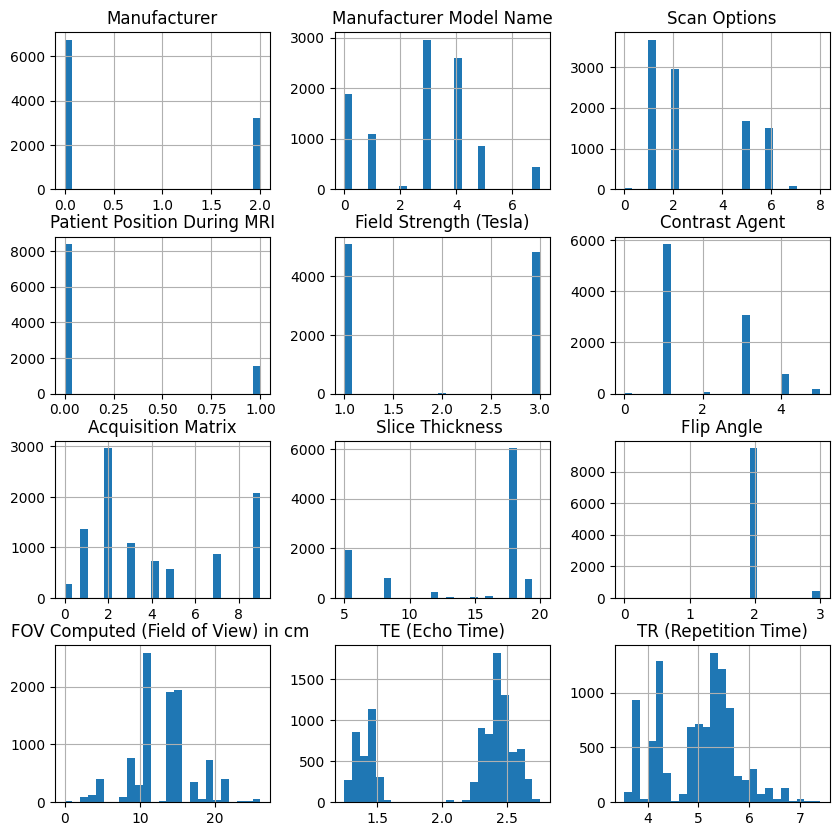

val


<Figure size 640x480 with 0 Axes>

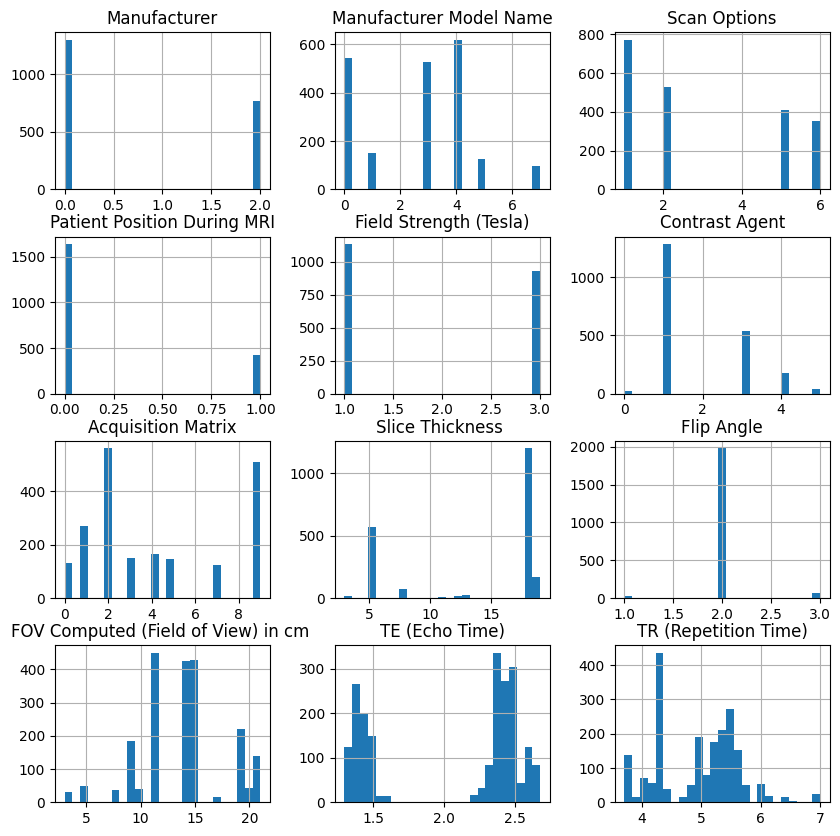

test


<Figure size 640x480 with 0 Axes>

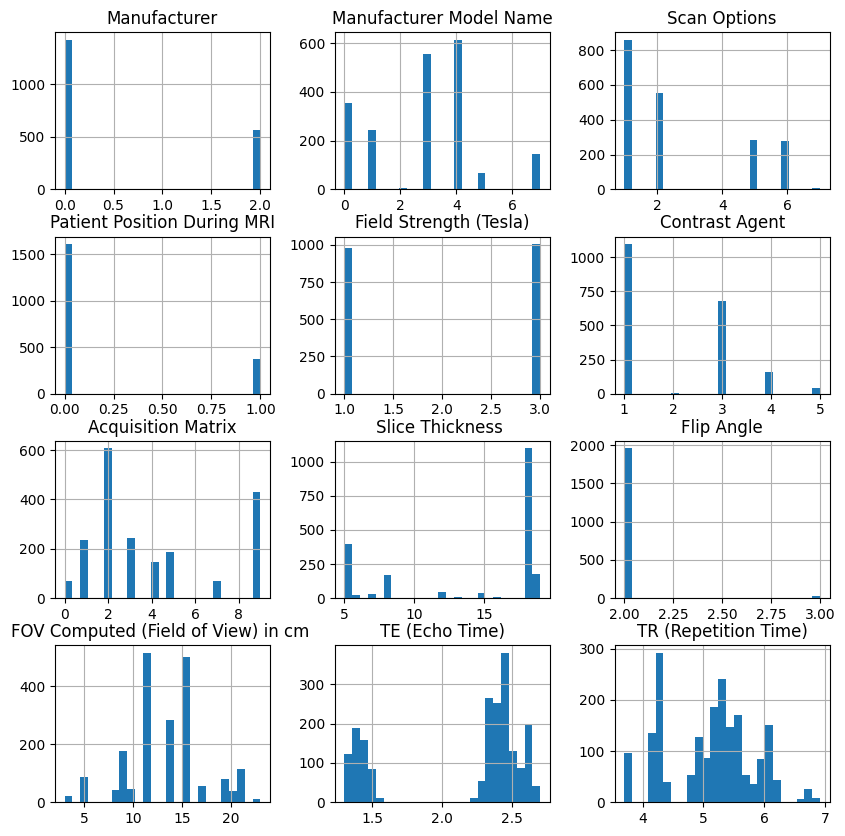

In [14]:
import matplotlib.pyplot as plt
save_dir = 'IAP_analyses/IAP_dists'
for dset_name, data_df in data_dfs.items():
    print(dset_name)
    # display(data_df)
    plt.figure()
    df_corr = data_df.rename(columns={"Flip Angle \n": "Flip Angle"}).hist(figsize=(10,10), bins=25)
    plt.savefig((os.path.join(save_dir, '{}.pdf'.format(dset_name))))
    plt.show()

## see if combinations of IAPs overlap between train and test sets

see the overlap between two subsets in terms of common IAP combinations (e.g. bw train and test)

for subsets A and B: (1) how many unique combos only in A, (2) how many unique combos only in B, (3) how many unique combos in both

In [23]:
for dset_nameA, data_dfA in data_dfs.items():
    for dset_nameB, data_dfB in data_dfs.items():
        if dset_nameA != dset_nameB:
            # keep only unique IAP combinations
            data_dfA_unique = data_dfA.drop_duplicates().values.tolist()
            data_dfB_unique = data_dfB.drop_duplicates().values.tolist()
            
            # convert list of lists to list of tuples
            data_dfA_unique = [tuple(l) for l in data_dfA_unique]
            data_dfB_unique = [tuple(l) for l in data_dfB_unique]
        
            combos_A = set(data_dfA_unique)
            combos_B = set(data_dfB_unique)
            
            num_only_inA = len(combos_A - combos_B)
            num_only_inB = len(combos_B - combos_A)
            num_inboth = len(combos_A & combos_B)
            
            print('{} and {}:\t A - B: {} B - A: {} AuB: {}'.format(dset_nameA, dset_nameB, num_only_inA, num_only_inB, num_inboth))

train and val:	 A - B: 385 B - A: 61 AuB: 44
train and test:	 A - B: 386 B - A: 71 AuB: 43
val and train:	 A - B: 61 B - A: 385 AuB: 44
val and test:	 A - B: 88 B - A: 97 AuB: 17
test and train:	 A - B: 71 B - A: 386 AuB: 43
test and val:	 A - B: 97 B - A: 88 AuB: 17
